In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [21]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [22]:
df = pd.read_csv("housing.csv").fillna(0)

In [23]:
df['rooms_per_household'] = df.total_rooms / df.households
df['bedrooms_per_room'] = df.total_rooms / df.total_rooms
df['population_per_household'] = df.population / df.households
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.0,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,1.0,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.0,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.0,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.0,2.181467


# Q1

In [24]:
df.ocean_proximity.mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

# Q2

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
df_full_train,df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_train,df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [27]:
len(df_train),len(df_val),len(df_test)

(12384, 4128, 4128)

In [28]:
y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

In [29]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [30]:
df_train.dtypes

longitude                   float64
latitude                    float64
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
ocean_proximity              object
rooms_per_household         float64
bedrooms_per_room           float64
population_per_household    float64
dtype: object

In [31]:
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
             'rooms_per_household', 'bedrooms_per_room','population_per_household']

<AxesSubplot:>

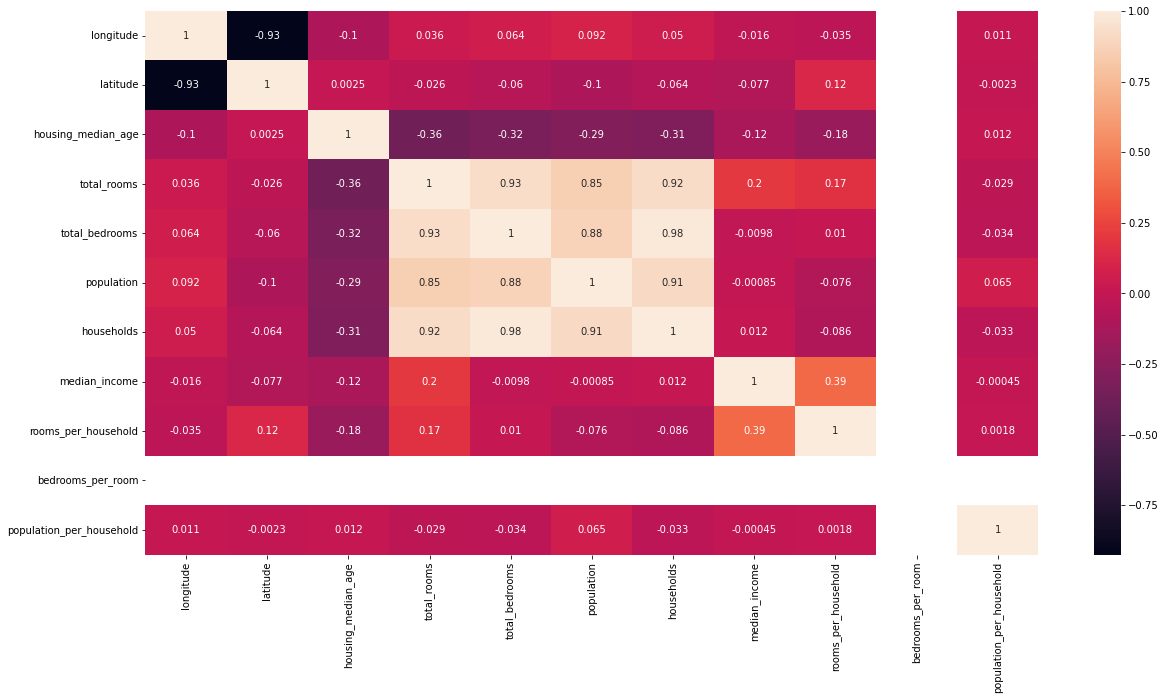

In [32]:
corr = df_train[numerical].corr()
plt.figure(figsize = (20,10))
sns.heatmap(corr, annot = True)

In [33]:
top = 0

for col in corr.columns:
        
    del corr[col][col]
    maxi = abs(corr[col]).max()
    
    if maxi > top:
        top = maxi
        filteri = (abs(corr[col]) == maxi).values
        columns = [col, (col,corr[col][filteri].keys()[0])]
    

In [34]:
columns

['total_bedrooms', ('total_bedrooms', 'households')]

In [35]:
avg = df.median_house_value.mean()
avg

206855.81690891474

In [36]:
y_og_train = y_train
y_og_val = y_val
y_og_test = y_test

In [37]:
y_train = (y_train > avg).astype(int)
y_val = (y_val > avg).astype(int)
y_test = (y_test > avg).astype(int)

In [38]:
# df["binary_median"] = (df.median_house_value > avg).astype(int)
# df_train["binary_median"] = (df_train.median_house_value > avg).astype(int)
# df.head()

# Q3

In [39]:
categorical = ['ocean_proximity']

In [40]:
from sklearn.metrics import mutual_info_score

In [41]:
mutual_info_score(df_train[categorical[0]], y_train).round(2)

0.1

# Q4

## One-hot encoder

In [42]:
from sklearn.feature_extraction import DictVectorizer

In [43]:
dv = DictVectorizer(sparse=True)

In [44]:
df_train_dict = df_train[categorical + numerical].to_dict(orient='records')
df_val_dict = df_val[categorical + numerical].to_dict(orient='records')

In [45]:
X_train = dv.fit_transform(df_train_dict)
X_val = dv.fit_transform(df_val_dict)

## Linear Regression

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)

In [48]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [49]:
y_pred = model.predict(X_val)

In [50]:
((y_pred == y_val).sum()/len(df_val)).round(2)

0.84

In [51]:
og_accuracy = ((y_pred == y_val).sum()/len(df_val))
og_accuracy

0.8355135658914729

# Q5

## Feature elimination

In [52]:
elimination_list = ['total_rooms','total_bedrooms','population','households']

In [53]:
for i in range(len(elimination_list)):
    print(elimination_list[i])
    
    # dict prep
    df_train_dict = df_train[categorical + numerical].loc[:, df_train.columns!=elimination_list[i]].to_dict(orient='records')
    df_val_dict = df_val[categorical + numerical].loc[:, df_train.columns!=elimination_list[i]].to_dict(orient='records')
    
    X_train = dv.fit_transform(df_train_dict)
    X_val = dv.fit_transform(df_val_dict)
    
    #modelling    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    elimination_accuracy = ((y_pred == y_val).sum()/len(df_val))
    print("elimination accuracy:", elimination_accuracy)
    print("elimination accuracy-diff:", elimination_accuracy - og_accuracy)

total_rooms
elimination accuracy: 0.8318798449612403
elimination accuracy-diff: -0.003633720930232509
total_bedrooms
elimination accuracy: 0.8364825581395349
elimination accuracy-diff: 0.0009689922480620172
population
elimination accuracy: 0.8352713178294574
elimination accuracy-diff: -0.0002422480620154488
households
elimination accuracy: 0.8265503875968992
elimination accuracy-diff: -0.008963178294573604


In [54]:
'population'

'population'

# Q6

In [55]:
y_log_train = y_og_train.apply(np.log)
y_log_val = y_og_val.apply(np.log)
y_log_test = y_og_test.apply(np.log)

In [56]:
from sklearn.linear_model import Ridge

In [57]:
def rmse(y,y_pred):
    se = (y-y_pred)**2    
    mse = se.mean()
    
    return np.sqrt(mse)

In [77]:
a = dict()

In [78]:
for i in [0,0.01,0.1,1,10]:
    
    model = Ridge(alpha=i, solver="sag", random_state=42)
    model.fit(X_train,y_log_train)
    y_pred = model.predict(X_val)
    
    a[i] = rmse(y_log_val,y_pred)
    

In [79]:
min(a, key=a.get)

0

In [80]:
a

{0: 0.542442616331935,
 0.01: 0.5424426163576459,
 0.1: 0.542442616563338,
 1: 0.5424426186511258,
 10: 0.5424426395135263}